In [1]:
from speck import SpeckCipher
import sys
import os

import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import json

import pytz
from datetime import datetime

import urllib.request, urllib.error, urllib.parse

import numpy as np

import matplotlib.pyplot as plt

pd.options.display.max_columns = None
uploadFormat = True
numOfChunks = 60
source = 'Download' # can be 'Download' for downloading direclty of the web, 
                    # or 'Folder' for reading from a folder

# If you are working files in a folder then this is the name of the directory where the files are stored
# if you have downloaded this off git you will need to change this!
directory_in_str = '/home/lifegarb/Documents/Work/Projects/211025_Voi_scooter_feasiability/data/on_bike/231023'

# if you are downloading them straight from James's site then you will need to specify the time range
    
# these are the times between which we are going to download and process the files
download_start = datetime(2023, 10, 16, 0, 0)
download_end = datetime(2023, 10, 27, 0, 0)

In [2]:
# before converting to a data frame, all the data is going to go into a list of dicts, this list is called:
data = []

# and this is decode key for the spec incryption
key_string = '{0xad, 0x1c, 0x4b, 0x6, 0x5c, 0x85, 0x2a, 0x48, 0xe4, 0xed, 0x33, 0x23, 0x4c, 0x9f, 0xed, 0x56, 0x23, 0x46, 0x59, 0xfa, 0x3c, 0x70, 0x82, 0x97, 0x45, 0xbd, 0x2b, 0xf1, 0xdc, 0xf4, 0xb6, 0xce}'

# the key string format above is how the teensy needs in, we convert it into an int for python thusly:
# we can convert into somethign this code can use by doing this:
key = [int(i,16) for i in key_string[1:-1].split(',')]

# and now with the key wecan set up our Speck Decryptre
my_speck = SpeckCipher(int.from_bytes(bytes(key), byteorder='big'), key_size=256, block_size=128)

In [3]:
def ddmm_to_degrees(ddmm):
    degrees, minutes = ddmm.astype('float64').divmod(100)
    return (degrees + minutes/60)

def missing_data(series):
    return series == '-'

In [4]:
if source == 'Folder':
       
    directory = os.fsencode(directory_in_str)

    # we are going to iterate through the files
    for fileBytes in os.listdir(directory):
        # get the name of the file, to see if it has the correct extention 
        filename = os.fsdecode(fileBytes)
        # and if it does, we process it
        if filename.endswith(".bin"):
            print('Checking {}'.format(filename))
            with open(os.path.join(directory, fileBytes), 'r') as file:
                line_count = 0
                # go through the file line by line
                # check the line isn't blank
                for line in file:
                    if line == '\n':
                        continue
                    if uploadFormat:
                        # this means that the file is in the funny format that you seem to get when
                        # uploading via Strings from the sensor to James's server. We have to convert 
                        # it into the normal format
                        while True:
                            line_part = file.readline()
                            if (line_part == '\n' or line_part == ''):
                                break
                            line = line.strip() + line_part.strip();
                    # we need a line encramter so that we can tell the user where there are errors
                    line_count = line_count + 1
                    # and this is going to be the string into which we save the decoded ascii
                    DecodedAsciiLine = ''

                    # each line is encoded into a number of encoded chunks, at the moment that number is 60,
                    # although it might change so I've put it in a variable.
                    for i in range(numOfChunks):
                        encChunk = line[i*32:(i*32)+32]
                        try:
                            CipherTextChunk = int(encChunk, 16)
                        except ValueError:
                            print("Could not convert to int in {}, line {}, chunk {}, could not decrypt".format(
                                filename,line_count,i), 
                                file=sys.stderr)
                        PlaneTextChunk = hex(my_speck.decrypt(CipherTextChunk))

                        # now decode the hex to ascii

                        # so the message ends with guff, so we have to look out for the nulll byte,
                        # which signifies the end.
                        # convert to a byte array
                        # we cut off the first two characters because they are the '0x' signifing hex
                        try:
                            PlaneByteArray =  bytearray.fromhex(PlaneTextChunk[2:])
                        except ValueError:
                            print("Non-Hex Value found in line {}, chunk {}, could not decrypt".format(
                                filename,line_count,i), 
                                file=sys.stderr)
                            AsciiChunk = ''
                        # look for the null character
                        nullLoc = PlaneByteArray.find(b'\00')

                        # if the location returned is 0 or higher then there is a null character in there
                        # and we must ignore everything after it
                        if (nullLoc > -1):
                            try:
                                AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:])[0:nullLoc].decode()
                            except UnicodeDecodeError:
                                print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                                    filename, line_count, i), file=sys.stderr)
                                AsciiChunk = ''
                            except ValueError:
                                print("Non-Hex Value found in {}, line {}, chunk {}, could not convert to ascii".format(
                                    filename, line_count,i), 
                                    file=sys.stderr)
                                AsciiChunk = ''
                        else:
                            try:
                                AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:]).decode()
                            except UnicodeDecodeError:
                                print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                                    filename, line_count, i), file=sys.stderr)
                                AsciiChunk = ''
                            except ValueError:
                                print("Non-Hex Value found in line {}, chunk {}, could not convert to ascii".format(
                                    filename, line_count,i), 
                                    file=sys.stderr)
                                AsciiChunk = ''
                        # and concat the new block onto the exisiting string
                        DecodedAsciiLine = DecodedAsciiLine + AsciiChunk

                        # if we found the null character then we have reached the end of the message and can 
                        # break the loop
                        if (nullLoc > -1):
                            break
                    # now we are going to try and decode the json string and convert it into a nested data structure
                    try:
                        data.append(json.loads(DecodedAsciiLine.strip()))
                    except ValueError:
                        # if it doesn't work, then try and output it.
                        print('Error Decoding JSON in {}, on line {}'.format(filename, line_count),
                              file=sys.stderr
                             )
                continue
        else:
            continue

In [5]:
if source == 'Download':
    url = 'https://london.localair.uk/data/archive/'

    response = urllib.request.urlopen(url)

    wc = response.read().decode('UTF-8')

    fileName = []
    timestamp = []

    for i in wc.split('"'):
        if i[-4:] == '.bin':
            fileName.append(i)
            timestamp.append(datetime.strptime(i, '%Y%m%d_%H%M%S_%f.bin'))
        
    df_files = pd.DataFrame({'FileName':fileName, 'TimeStamp': timestamp})

    mask = (df_files['TimeStamp'] > download_start) & (df_files['TimeStamp'] < download_end)
    
    for file in df_files[mask]['FileName']:
        filename = file
        response = urllib.request.urlopen(url+file)
        wc = response.read().decode('UTF-8')
        line_count = 0
        for line in wc.split('\n\n'):
            if line == '':
                continue
            line = line.replace('\n', "")
            # we need a line encramter so that we can tell the user where there are errors
            line_count = line_count + 1
            # and this is going to be the string into which we save the decoded ascii
            DecodedAsciiLine = ''

            # each line is encoded into a number of encoded chunks, at the moment that number is 60,
            # although it might change so I've put it in a variable.
            for i in range(numOfChunks):
                encChunk = line[i*32:(i*32)+32]
                try:
                    CipherTextChunk = int(encChunk, 16)
                except ValueError:
                    print("Could not convert to int in {}, line {}, chunk {}, could not decrypt".format(
                        filename,line_count,i), 
                        file=sys.stderr)
                PlaneTextChunk = hex(my_speck.decrypt(CipherTextChunk))

                # now decode the hex to ascii

                # so the message ends with guff, so we have to look out for the nulll byte,
                # which signifies the end.
                # convert to a byte array
                # we cut off the first two characters because they are the '0x' signifing hex
                try:
                    PlaneByteArray =  bytearray.fromhex(PlaneTextChunk[2:])
                except ValueError:
                    print("Non-Hex Value found in line {}, chunk {}, could not decrypt".format(
                        filename,line_count,i), 
                        file=sys.stderr)
                    AsciiChunk = ''
                # look for the null character
                nullLoc = PlaneByteArray.find(b'\00')

                # if the location returned is 0 or higher then there is a null character in there
                # and we must ignore everything after it
                if (nullLoc > -1):
                    try:
                        AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:])[0:nullLoc].decode()
                    except UnicodeDecodeError:
                        print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                            filename, line_count, i), file=sys.stderr)
                        AsciiChunk = ''
                    except ValueError:
                        print("Non-Hex Value found in {}, line {}, chunk {}, could not convert to ascii".format(
                            filename, line_count,i), 
                            file=sys.stderr)
                        AsciiChunk = ''
                else:
                    try:
                        AsciiChunk = bytearray.fromhex(PlaneTextChunk[2:]).decode()
                    except UnicodeDecodeError:
                        print('Error in {}, line {}, chunk {}, count not convert to ascii'.format(
                            filename, line_count, i), file=sys.stderr)
                        AsciiChunk = ''
                    except ValueError:
                        print("Non-Hex Value found in line {}, chunk {}, could not convert to ascii".format(
                            filename, line_count,i), 
                            file=sys.stderr)
                        AsciiChunk = ''
                # and concat the new block onto the exisiting string
                DecodedAsciiLine = DecodedAsciiLine + AsciiChunk

                # if we found the null character then we have reached the end of the message and can 
                # break the loop
                if (nullLoc > -1):
                    break
            # now we are going to try and decode the json string and convert it into a nested data structure
            try:
                data.append(json.loads(DecodedAsciiLine.strip()))
            except ValueError:
                # if it doesn't work, then try and output it.
                print('Error Decoding JSON in {}, on line {}'.format(filename, line_count),
                      file=sys.stderr
                     )
        continue

Could not convert to int in 20231016_145831_5791.bin, line 1, chunk 0, could not decrypt
Error Decoding JSON in 20231016_145831_5791.bin, on line 1
Error Decoding JSON in 20231016_150818_4419.bin, on line 1
Error in 20231016_162434_1232.bin, line 1, chunk 0, count not convert to ascii
Could not convert to int in 20231016_162434_1232.bin, line 1, chunk 1, could not decrypt
Error in 20231016_162434_1232.bin, line 1, chunk 1, count not convert to ascii
Could not convert to int in 20231016_162434_1232.bin, line 1, chunk 2, could not decrypt
Error in 20231016_162434_1232.bin, line 1, chunk 2, count not convert to ascii
Could not convert to int in 20231016_162434_1232.bin, line 1, chunk 3, could not decrypt
Error in 20231016_162434_1232.bin, line 1, chunk 3, count not convert to ascii
Could not convert to int in 20231016_162434_1232.bin, line 1, chunk 4, could not decrypt
Error in 20231016_162434_1232.bin, line 1, chunk 4, count not convert to ascii
Could not convert to int in 20231016_16243

Error Decoding JSON in 20231017_115229_9895.bin, on line 1
Error Decoding JSON in 20231017_115229_9895.bin, on line 6
Error in 20231017_115245_3168.bin, line 1, chunk 32, count not convert to ascii
Error in 20231017_115245_3168.bin, line 1, chunk 33, count not convert to ascii
Error in 20231017_115245_3168.bin, line 1, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_115245_3168.bin, chunk 1, could not decrypt
Non-Hex Value found in line 20231017_115245_3168.bin, chunk 1, could not convert to ascii
Error in 20231017_115245_3168.bin, line 1, chunk 36, count not convert to ascii
Error in 20231017_115245_3168.bin, line 1, chunk 37, count not convert to ascii
Error in 20231017_115245_3168.bin, line 3, chunk 32, count not convert to ascii
Error in 20231017_115245_3168.bin, line 3, chunk 33, count not convert to ascii
Error in 20231017_115245_3168.bin, line 3, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_115245_3168.bin, chunk 3, could no

Error Decoding JSON in 20231017_115348_8296.bin, on line 3
Error Decoding JSON in 20231017_115348_8296.bin, on line 8
Error Decoding JSON in 20231017_115348_8296.bin, on line 10
Error in 20231017_115348_8296.bin, line 12, chunk 32, count not convert to ascii
Error in 20231017_115348_8296.bin, line 12, chunk 33, count not convert to ascii
Error in 20231017_115348_8296.bin, line 12, chunk 34, count not convert to ascii
Error in 20231017_115348_8296.bin, line 12, chunk 35, count not convert to ascii
Error in 20231017_115348_8296.bin, line 12, chunk 36, count not convert to ascii
Error in 20231017_115348_8296.bin, line 12, chunk 37, count not convert to ascii
Error in 20231017_115348_8296.bin, line 12, chunk 38, count not convert to ascii
Error in 20231017_115348_8296.bin, line 12, chunk 39, count not convert to ascii
Error in 20231017_115348_8296.bin, line 12, chunk 40, count not convert to ascii
Error in 20231017_115348_8296.bin, line 12, chunk 41, count not convert to ascii
Error in 202

Error Decoding JSON in 20231017_115627_6832.bin, on line 1
Error Decoding JSON in 20231017_115627_6832.bin, on line 6
Error in 20231017_115644_3061.bin, line 1, chunk 32, count not convert to ascii
Error in 20231017_115644_3061.bin, line 1, chunk 33, count not convert to ascii
Error in 20231017_115644_3061.bin, line 1, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_115644_3061.bin, chunk 1, could not decrypt
Non-Hex Value found in line 20231017_115644_3061.bin, chunk 1, could not convert to ascii
Error in 20231017_115644_3061.bin, line 1, chunk 36, count not convert to ascii
Error in 20231017_115644_3061.bin, line 1, chunk 37, count not convert to ascii
Error in 20231017_115644_3061.bin, line 3, chunk 32, count not convert to ascii
Error in 20231017_115644_3061.bin, line 3, chunk 33, count not convert to ascii
Error in 20231017_115644_3061.bin, line 3, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_115644_3061.bin, chunk 3, could no

Error Decoding JSON in 20231017_115745_5176.bin, on line 3
Error Decoding JSON in 20231017_115745_5176.bin, on line 8
Error Decoding JSON in 20231017_115745_5176.bin, on line 10
Error in 20231017_115745_5176.bin, line 12, chunk 32, count not convert to ascii
Error in 20231017_115745_5176.bin, line 12, chunk 33, count not convert to ascii
Error in 20231017_115745_5176.bin, line 12, chunk 34, count not convert to ascii
Error in 20231017_115745_5176.bin, line 12, chunk 35, count not convert to ascii
Error in 20231017_115745_5176.bin, line 12, chunk 36, count not convert to ascii
Error in 20231017_115745_5176.bin, line 12, chunk 37, count not convert to ascii
Error in 20231017_115745_5176.bin, line 12, chunk 38, count not convert to ascii
Error in 20231017_115745_5176.bin, line 12, chunk 39, count not convert to ascii
Error in 20231017_115745_5176.bin, line 12, chunk 40, count not convert to ascii
Error in 20231017_115745_5176.bin, line 12, chunk 41, count not convert to ascii
Error in 202

Error in 20231017_120507_7578.bin, line 1, chunk 32, count not convert to ascii
Error in 20231017_120507_7578.bin, line 1, chunk 33, count not convert to ascii
Error in 20231017_120507_7578.bin, line 1, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_120507_7578.bin, chunk 1, could not decrypt
Non-Hex Value found in line 20231017_120507_7578.bin, chunk 1, could not convert to ascii
Error in 20231017_120507_7578.bin, line 1, chunk 36, count not convert to ascii
Error in 20231017_120507_7578.bin, line 1, chunk 37, count not convert to ascii
Error in 20231017_120507_7578.bin, line 1, chunk 38, count not convert to ascii
Error in 20231017_120507_7578.bin, line 1, chunk 39, count not convert to ascii
Error in 20231017_120507_7578.bin, line 1, chunk 40, count not convert to ascii
Error in 20231017_120507_7578.bin, line 1, chunk 41, count not convert to ascii
Error in 20231017_120507_7578.bin, line 1, chunk 42, count not convert to ascii
Error in 20231017_120507_7578

Error in 20231017_121532_5130.bin, line 2, chunk 32, count not convert to ascii
Error in 20231017_121532_5130.bin, line 2, chunk 33, count not convert to ascii
Error in 20231017_121532_5130.bin, line 2, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_121532_5130.bin, chunk 2, could not decrypt
Non-Hex Value found in line 20231017_121532_5130.bin, chunk 2, could not convert to ascii
Error in 20231017_121532_5130.bin, line 2, chunk 36, count not convert to ascii
Error in 20231017_121532_5130.bin, line 2, chunk 37, count not convert to ascii
Error in 20231017_121532_5130.bin, line 2, chunk 38, count not convert to ascii
Error in 20231017_121532_5130.bin, line 2, chunk 39, count not convert to ascii
Error in 20231017_121532_5130.bin, line 2, chunk 40, count not convert to ascii
Error in 20231017_121532_5130.bin, line 2, chunk 41, count not convert to ascii
Error in 20231017_121532_5130.bin, line 2, chunk 42, count not convert to ascii
Error in 20231017_121532_5130

Error in 20231017_141718_1319.bin, line 38, chunk 32, count not convert to ascii
Error in 20231017_141718_1319.bin, line 38, chunk 33, count not convert to ascii
Error in 20231017_141718_1319.bin, line 38, chunk 34, count not convert to ascii
Error in 20231017_141718_1319.bin, line 38, chunk 35, count not convert to ascii
Error in 20231017_141718_1319.bin, line 38, chunk 36, count not convert to ascii
Error in 20231017_141718_1319.bin, line 38, chunk 37, count not convert to ascii
Error in 20231017_141718_1319.bin, line 38, chunk 38, count not convert to ascii
Error in 20231017_141718_1319.bin, line 38, chunk 39, count not convert to ascii
Error in 20231017_141718_1319.bin, line 38, chunk 40, count not convert to ascii
Error in 20231017_141718_1319.bin, line 38, chunk 41, count not convert to ascii
Error in 20231017_141718_1319.bin, line 38, chunk 42, count not convert to ascii
Error in 20231017_141718_1319.bin, line 38, chunk 43, count not convert to ascii
Error in 20231017_141718_131

Error in 20231017_145300_9449.bin, line 38, chunk 36, count not convert to ascii
Error in 20231017_145300_9449.bin, line 38, chunk 37, count not convert to ascii
Error in 20231017_145300_9449.bin, line 38, chunk 38, count not convert to ascii
Error in 20231017_145300_9449.bin, line 38, chunk 39, count not convert to ascii
Error in 20231017_145300_9449.bin, line 38, chunk 40, count not convert to ascii
Error in 20231017_145300_9449.bin, line 38, chunk 41, count not convert to ascii
Error in 20231017_145300_9449.bin, line 38, chunk 42, count not convert to ascii
Error in 20231017_145300_9449.bin, line 38, chunk 43, count not convert to ascii
Error in 20231017_145300_9449.bin, line 44, chunk 32, count not convert to ascii
Error in 20231017_145300_9449.bin, line 44, chunk 33, count not convert to ascii
Error in 20231017_145300_9449.bin, line 44, chunk 34, count not convert to ascii
Error in 20231017_145300_9449.bin, line 44, chunk 35, count not convert to ascii
Error in 20231017_145300_944

Error in 20231017_145339_7202.bin, line 1, chunk 32, count not convert to ascii
Error in 20231017_145339_7202.bin, line 1, chunk 33, count not convert to ascii
Error in 20231017_145339_7202.bin, line 1, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_145339_7202.bin, chunk 1, could not decrypt
Non-Hex Value found in line 20231017_145339_7202.bin, chunk 1, could not convert to ascii
Error in 20231017_145339_7202.bin, line 1, chunk 36, count not convert to ascii
Error in 20231017_145339_7202.bin, line 1, chunk 37, count not convert to ascii
Error in 20231017_145339_7202.bin, line 3, chunk 32, count not convert to ascii
Error in 20231017_145339_7202.bin, line 3, chunk 33, count not convert to ascii
Error in 20231017_145339_7202.bin, line 3, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_145339_7202.bin, chunk 3, could not decrypt
Non-Hex Value found in line 20231017_145339_7202.bin, chunk 3, could not convert to ascii
Error in 20231017_

Error Decoding JSON in 20231017_145428_8665.bin, on line 117
Error Decoding JSON in 20231017_145428_8665.bin, on line 119
Error Decoding JSON in 20231017_145428_8665.bin, on line 123
Error in 20231017_145428_8665.bin, line 128, chunk 11, count not convert to ascii
Error Decoding JSON in 20231017_145428_8665.bin, on line 128
Error in 20231017_145428_8665.bin, line 141, chunk 32, count not convert to ascii
Error in 20231017_145428_8665.bin, line 141, chunk 33, count not convert to ascii
Error in 20231017_145428_8665.bin, line 141, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_145428_8665.bin, chunk 141, could not decrypt
Non-Hex Value found in line 20231017_145428_8665.bin, chunk 141, could not convert to ascii
Error in 20231017_145428_8665.bin, line 141, chunk 36, count not convert to ascii
Error in 20231017_145428_8665.bin, line 141, chunk 37, count not convert to ascii
Error in 20231017_145428_8665.bin, line 141, chunk 38, count not convert to ascii
Error i

Error in 20231017_145440_5866.bin, line 1, chunk 32, count not convert to ascii
Error in 20231017_145440_5866.bin, line 1, chunk 33, count not convert to ascii
Error in 20231017_145440_5866.bin, line 1, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_145440_5866.bin, chunk 1, could not decrypt
Non-Hex Value found in line 20231017_145440_5866.bin, chunk 1, could not convert to ascii
Error in 20231017_145440_5866.bin, line 1, chunk 36, count not convert to ascii
Error in 20231017_145440_5866.bin, line 1, chunk 37, count not convert to ascii
Error in 20231017_145440_5866.bin, line 2, chunk 32, count not convert to ascii
Error in 20231017_145440_5866.bin, line 2, chunk 33, count not convert to ascii
Error in 20231017_145440_5866.bin, line 2, chunk 34, count not convert to ascii
Non-Hex Value found in line 20231017_145440_5866.bin, chunk 2, could not decrypt
Non-Hex Value found in line 20231017_145440_5866.bin, chunk 2, could not convert to ascii
Error in 20231017_

Error in 20231017_145510_8024.bin, line 2, chunk 32, count not convert to ascii
Error in 20231017_145510_8024.bin, line 2, chunk 33, count not convert to ascii
Error in 20231017_145510_8024.bin, line 2, chunk 34, count not convert to ascii
Error in 20231017_145510_8024.bin, line 8, chunk 32, count not convert to ascii
Error in 20231017_145510_8024.bin, line 8, chunk 33, count not convert to ascii
Error in 20231017_145510_8024.bin, line 8, chunk 34, count not convert to ascii
Error in 20231017_145517_6793.bin, line 2, chunk 32, count not convert to ascii
Error in 20231017_145517_6793.bin, line 2, chunk 33, count not convert to ascii
Error in 20231017_145517_6793.bin, line 2, chunk 34, count not convert to ascii
Error in 20231017_145517_6793.bin, line 3, chunk 32, count not convert to ascii
Error in 20231017_145517_6793.bin, line 3, chunk 33, count not convert to ascii
Error in 20231017_145517_6793.bin, line 3, chunk 34, count not convert to ascii
Error in 20231017_145517_6793.bin, line 

Error in 20231017_154639_6478.bin, line 1, chunk 32, count not convert to ascii
Error in 20231017_154639_6478.bin, line 1, chunk 33, count not convert to ascii
Error in 20231017_154639_6478.bin, line 1, chunk 34, count not convert to ascii
Error in 20231017_154639_6478.bin, line 1, chunk 35, count not convert to ascii
Error in 20231017_154639_6478.bin, line 1, chunk 36, count not convert to ascii
Error in 20231017_154639_6478.bin, line 1, chunk 37, count not convert to ascii
Error in 20231017_154639_6478.bin, line 1, chunk 38, count not convert to ascii
Error in 20231017_154639_6478.bin, line 1, chunk 39, count not convert to ascii
Error in 20231017_154639_6478.bin, line 1, chunk 40, count not convert to ascii
Error in 20231017_154639_6478.bin, line 1, chunk 41, count not convert to ascii
Error in 20231017_154639_6478.bin, line 1, chunk 42, count not convert to ascii
Error in 20231017_154639_6478.bin, line 1, chunk 43, count not convert to ascii
Error in 20231017_154639_6478.bin, line 

Error in 20231017_155440_3297.bin, line 7, chunk 32, count not convert to ascii
Error in 20231017_155440_3297.bin, line 7, chunk 33, count not convert to ascii
Error in 20231017_155440_3297.bin, line 7, chunk 34, count not convert to ascii
Error in 20231017_155440_3297.bin, line 7, chunk 35, count not convert to ascii
Error in 20231017_155440_3297.bin, line 7, chunk 36, count not convert to ascii
Error in 20231017_155440_3297.bin, line 7, chunk 37, count not convert to ascii
Error in 20231017_155440_3297.bin, line 7, chunk 38, count not convert to ascii
Error in 20231017_155440_3297.bin, line 7, chunk 39, count not convert to ascii
Error in 20231017_155440_3297.bin, line 7, chunk 40, count not convert to ascii
Error in 20231017_155440_3297.bin, line 7, chunk 41, count not convert to ascii
Error in 20231017_155440_3297.bin, line 7, chunk 42, count not convert to ascii
Error in 20231017_155440_3297.bin, line 7, chunk 43, count not convert to ascii
Error in 20231017_155440_3297.bin, line 

Error in 20231017_160640_6608.bin, line 10, chunk 32, count not convert to ascii
Error in 20231017_160640_6608.bin, line 10, chunk 33, count not convert to ascii
Error in 20231017_160640_6608.bin, line 10, chunk 34, count not convert to ascii
Error in 20231017_160640_6608.bin, line 10, chunk 35, count not convert to ascii
Error in 20231017_160640_6608.bin, line 10, chunk 36, count not convert to ascii
Error in 20231017_160640_6608.bin, line 10, chunk 37, count not convert to ascii
Error in 20231017_160640_6608.bin, line 10, chunk 38, count not convert to ascii
Error in 20231017_160640_6608.bin, line 10, chunk 39, count not convert to ascii
Error in 20231017_160640_6608.bin, line 10, chunk 40, count not convert to ascii
Error in 20231017_160640_6608.bin, line 10, chunk 41, count not convert to ascii
Error in 20231017_160640_6608.bin, line 10, chunk 42, count not convert to ascii
Error in 20231017_160640_6608.bin, line 10, chunk 43, count not convert to ascii
Error in 20231017_160640_660

Error in 20231017_161643_6073.bin, line 4, chunk 32, count not convert to ascii
Error in 20231017_161643_6073.bin, line 4, chunk 33, count not convert to ascii
Error in 20231017_161643_6073.bin, line 4, chunk 34, count not convert to ascii
Error in 20231017_161643_6073.bin, line 4, chunk 35, count not convert to ascii
Error in 20231017_161643_6073.bin, line 4, chunk 36, count not convert to ascii
Error in 20231017_161643_6073.bin, line 4, chunk 37, count not convert to ascii
Error in 20231017_161643_6073.bin, line 4, chunk 38, count not convert to ascii
Error in 20231017_161643_6073.bin, line 4, chunk 39, count not convert to ascii
Error in 20231017_161643_6073.bin, line 4, chunk 40, count not convert to ascii
Error in 20231017_161643_6073.bin, line 4, chunk 41, count not convert to ascii
Error in 20231017_161643_6073.bin, line 4, chunk 42, count not convert to ascii
Error in 20231017_161643_6073.bin, line 4, chunk 43, count not convert to ascii
Error in 20231017_161643_6073.bin, line 

Error in 20231017_163243_4487.bin, line 3, chunk 32, count not convert to ascii
Error in 20231017_163243_4487.bin, line 3, chunk 33, count not convert to ascii
Error in 20231017_163243_4487.bin, line 6, chunk 32, count not convert to ascii
Error in 20231017_163243_4487.bin, line 6, chunk 33, count not convert to ascii
Error in 20231017_163243_4487.bin, line 7, chunk 32, count not convert to ascii
Error in 20231017_163243_4487.bin, line 7, chunk 33, count not convert to ascii
Error in 20231017_163243_4487.bin, line 8, chunk 32, count not convert to ascii
Error in 20231017_163243_4487.bin, line 8, chunk 33, count not convert to ascii
Error in 20231017_163439_5375.bin, line 3, chunk 32, count not convert to ascii
Error in 20231017_163439_5375.bin, line 3, chunk 33, count not convert to ascii
Error in 20231017_163439_5375.bin, line 3, chunk 34, count not convert to ascii
Error in 20231017_163439_5375.bin, line 3, chunk 35, count not convert to ascii
Error in 20231017_163439_5375.bin, line 

Error in 20231017_165243_0871.bin, line 6, chunk 32, count not convert to ascii
Error in 20231017_165243_0871.bin, line 6, chunk 33, count not convert to ascii
Error in 20231017_165440_2920.bin, line 5, chunk 32, count not convert to ascii
Error in 20231017_165440_2920.bin, line 5, chunk 33, count not convert to ascii
Error in 20231017_165440_2920.bin, line 5, chunk 34, count not convert to ascii
Error in 20231017_165440_2920.bin, line 5, chunk 35, count not convert to ascii
Error in 20231017_165440_2920.bin, line 5, chunk 36, count not convert to ascii
Error in 20231017_165440_2920.bin, line 5, chunk 37, count not convert to ascii
Error in 20231017_165440_2920.bin, line 5, chunk 38, count not convert to ascii
Error in 20231017_165440_2920.bin, line 5, chunk 39, count not convert to ascii
Error in 20231017_165440_2920.bin, line 5, chunk 40, count not convert to ascii
Error in 20231017_165440_2920.bin, line 5, chunk 41, count not convert to ascii
Error in 20231017_165440_2920.bin, line 

Error in 20231018_170443_1775.bin, line 2, chunk 32, count not convert to ascii
Error in 20231018_170443_1775.bin, line 2, chunk 33, count not convert to ascii
Error in 20231018_170443_1775.bin, line 2, chunk 34, count not convert to ascii
Error in 20231018_170443_1775.bin, line 2, chunk 35, count not convert to ascii
Error in 20231018_170443_1775.bin, line 2, chunk 36, count not convert to ascii
Error in 20231018_170443_1775.bin, line 2, chunk 37, count not convert to ascii
Error in 20231018_170443_1775.bin, line 2, chunk 38, count not convert to ascii
Error in 20231018_170443_1775.bin, line 2, chunk 39, count not convert to ascii
Error in 20231018_170443_1775.bin, line 2, chunk 40, count not convert to ascii
Error in 20231018_170443_1775.bin, line 2, chunk 41, count not convert to ascii
Error in 20231018_170443_1775.bin, line 2, chunk 42, count not convert to ascii
Error Decoding JSON in 20231018_170443_1775.bin, on line 5
Error Decoding JSON in 20231018_170443_1775.bin, on line 6
Er

Error Decoding JSON in 20231018_175821_2340.bin, on line 21
Error in 20231018_175821_2340.bin, line 38, chunk 35, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 36, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 37, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 38, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 39, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 40, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 41, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 42, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 43, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 44, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk 45, count not convert to ascii
Error in 20231018_175821_2340.bin, line 38, chunk

Error Decoding JSON in 20231018_175845_6855.bin, on line 136
Error Decoding JSON in 20231018_175845_6855.bin, on line 144
Error in 20231018_223227_7735.bin, line 1, chunk 33, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 34, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 35, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 36, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 37, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 38, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 39, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 40, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 41, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 42, count not convert to ascii
Error in 20231018_223227_7735.bin, line 1, chunk 43, count not convert to asci

Error Decoding JSON in 20231019_092702_2452.bin, on line 33
Error Decoding JSON in 20231019_092702_2452.bin, on line 34
Error Decoding JSON in 20231019_092702_2452.bin, on line 43
Error Decoding JSON in 20231019_092702_2452.bin, on line 47
Error Decoding JSON in 20231019_092702_2452.bin, on line 49
Error Decoding JSON in 20231019_092702_2452.bin, on line 51
Error Decoding JSON in 20231019_092702_2452.bin, on line 52
Error Decoding JSON in 20231019_092702_2452.bin, on line 54
Error Decoding JSON in 20231019_092702_2452.bin, on line 60
Error in 20231019_092702_2452.bin, line 76, chunk 22, count not convert to ascii
Could not convert to int in 20231019_092702_2452.bin, line 76, chunk 23, could not decrypt
Error in 20231019_092702_2452.bin, line 76, chunk 23, count not convert to ascii
Could not convert to int in 20231019_092702_2452.bin, line 76, chunk 24, could not decrypt
Error in 20231019_092702_2452.bin, line 76, chunk 24, count not convert to ascii
Could not convert to int in 2023101

Error Decoding JSON in 20231020_092004_8534.bin, on line 43
Error Decoding JSON in 20231020_092004_8534.bin, on line 47
Error Decoding JSON in 20231020_092004_8534.bin, on line 118
Error Decoding JSON in 20231020_092004_8534.bin, on line 119
Error Decoding JSON in 20231020_092004_8534.bin, on line 129
Error Decoding JSON in 20231020_092004_8534.bin, on line 138
Error Decoding JSON in 20231020_092004_8534.bin, on line 153
Error Decoding JSON in 20231020_092004_8534.bin, on line 160
Error Decoding JSON in 20231020_092004_8534.bin, on line 175
Error Decoding JSON in 20231020_092004_8534.bin, on line 244
Error Decoding JSON in 20231020_092004_8534.bin, on line 250
Error Decoding JSON in 20231020_092004_8534.bin, on line 252
Error Decoding JSON in 20231020_092004_8534.bin, on line 273
Error Decoding JSON in 20231020_092004_8534.bin, on line 274
Error in 20231020_092004_8534.bin, line 319, chunk 20, count not convert to ascii
Could not convert to int in 20231020_092004_8534.bin, line 319, ch

Error in 20231020_092024_1047.bin, line 94, chunk 13, count not convert to ascii
Could not convert to int in 20231020_092024_1047.bin, line 94, chunk 14, could not decrypt
Error in 20231020_092024_1047.bin, line 94, chunk 14, count not convert to ascii
Could not convert to int in 20231020_092024_1047.bin, line 94, chunk 15, could not decrypt
Error in 20231020_092024_1047.bin, line 94, chunk 15, count not convert to ascii
Could not convert to int in 20231020_092024_1047.bin, line 94, chunk 16, could not decrypt
Error in 20231020_092024_1047.bin, line 94, chunk 16, count not convert to ascii
Could not convert to int in 20231020_092024_1047.bin, line 94, chunk 17, could not decrypt
Error in 20231020_092024_1047.bin, line 94, chunk 17, count not convert to ascii
Could not convert to int in 20231020_092024_1047.bin, line 94, chunk 18, could not decrypt
Error in 20231020_092024_1047.bin, line 94, chunk 18, count not convert to ascii
Could not convert to int in 20231020_092024_1047.bin, line 

Error Decoding JSON in 20231020_172549_0344.bin, on line 55
Error Decoding JSON in 20231020_172549_0344.bin, on line 76
Error Decoding JSON in 20231020_172549_0344.bin, on line 91
Error Decoding JSON in 20231020_172549_0344.bin, on line 135
Error Decoding JSON in 20231020_172549_0344.bin, on line 138
Error Decoding JSON in 20231020_172549_0344.bin, on line 157
Error Decoding JSON in 20231020_172549_0344.bin, on line 168
Error Decoding JSON in 20231020_172549_0344.bin, on line 178
Error in 20231020_172549_0344.bin, line 187, chunk 26, count not convert to ascii
Could not convert to int in 20231020_172549_0344.bin, line 187, chunk 27, could not decrypt
Error in 20231020_172549_0344.bin, line 187, chunk 27, count not convert to ascii
Could not convert to int in 20231020_172549_0344.bin, line 187, chunk 28, could not decrypt
Error in 20231020_172549_0344.bin, line 187, chunk 28, count not convert to ascii
Could not convert to int in 20231020_172549_0344.bin, line 187, chunk 29, could not d

Error Decoding JSON in 20231020_172637_0889.bin, on line 8
Error Decoding JSON in 20231020_172637_0889.bin, on line 46
Error Decoding JSON in 20231020_172637_0889.bin, on line 53
Error Decoding JSON in 20231020_172637_0889.bin, on line 76
Error Decoding JSON in 20231020_172637_0889.bin, on line 78
Error Decoding JSON in 20231020_172637_0889.bin, on line 84
Error in 20231020_172637_0889.bin, line 103, chunk 8, count not convert to ascii
Could not convert to int in 20231020_172637_0889.bin, line 103, chunk 9, could not decrypt
Error in 20231020_172637_0889.bin, line 103, chunk 9, count not convert to ascii
Could not convert to int in 20231020_172637_0889.bin, line 103, chunk 10, could not decrypt
Error in 20231020_172637_0889.bin, line 103, chunk 10, count not convert to ascii
Could not convert to int in 20231020_172637_0889.bin, line 103, chunk 11, could not decrypt
Error in 20231020_172637_0889.bin, line 103, chunk 11, count not convert to ascii
Could not convert to int in 20231020_172

Error Decoding JSON in 20231020_172659_6547.bin, on line 71
Error Decoding JSON in 20231020_172659_6547.bin, on line 72
Error Decoding JSON in 20231020_172659_6547.bin, on line 112
Error Decoding JSON in 20231020_172659_6547.bin, on line 114
Error Decoding JSON in 20231020_172659_6547.bin, on line 115
Error in 20231020_172659_6547.bin, line 116, chunk 2, count not convert to ascii
Could not convert to int in 20231020_172659_6547.bin, line 116, chunk 3, could not decrypt
Error in 20231020_172659_6547.bin, line 116, chunk 3, count not convert to ascii
Could not convert to int in 20231020_172659_6547.bin, line 116, chunk 4, could not decrypt
Error in 20231020_172659_6547.bin, line 116, chunk 4, count not convert to ascii
Could not convert to int in 20231020_172659_6547.bin, line 116, chunk 5, could not decrypt
Error in 20231020_172659_6547.bin, line 116, chunk 5, count not convert to ascii
Could not convert to int in 20231020_172659_6547.bin, line 116, chunk 6, could not decrypt
Error in 

Error Decoding JSON in 20231020_172727_0468.bin, on line 28
Error Decoding JSON in 20231020_172727_0468.bin, on line 31
Error Decoding JSON in 20231020_172727_0468.bin, on line 41
Error in 20231020_172727_0468.bin, line 61, chunk 29, count not convert to ascii
Could not convert to int in 20231020_172727_0468.bin, line 61, chunk 30, could not decrypt
Error in 20231020_172727_0468.bin, line 61, chunk 30, count not convert to ascii
Could not convert to int in 20231020_172727_0468.bin, line 61, chunk 31, could not decrypt
Error in 20231020_172727_0468.bin, line 61, chunk 31, count not convert to ascii
Could not convert to int in 20231020_172727_0468.bin, line 61, chunk 32, could not decrypt
Error in 20231020_172727_0468.bin, line 61, chunk 32, count not convert to ascii
Could not convert to int in 20231020_172727_0468.bin, line 61, chunk 33, could not decrypt
Error in 20231020_172727_0468.bin, line 61, chunk 33, count not convert to ascii
Could not convert to int in 20231020_172727_0468.bi

Error Decoding JSON in 20231020_172817_6393.bin, on line 11
Error Decoding JSON in 20231020_172817_6393.bin, on line 150
Error Decoding JSON in 20231020_172817_6393.bin, on line 151
Error Decoding JSON in 20231020_172817_6393.bin, on line 154
Error Decoding JSON in 20231020_172817_6393.bin, on line 212
Error in 20231020_172817_6393.bin, line 236, chunk 2, count not convert to ascii
Could not convert to int in 20231020_172817_6393.bin, line 236, chunk 3, could not decrypt
Error in 20231020_172817_6393.bin, line 236, chunk 3, count not convert to ascii
Could not convert to int in 20231020_172817_6393.bin, line 236, chunk 4, could not decrypt
Error in 20231020_172817_6393.bin, line 236, chunk 4, count not convert to ascii
Could not convert to int in 20231020_172817_6393.bin, line 236, chunk 5, could not decrypt
Error in 20231020_172817_6393.bin, line 236, chunk 5, count not convert to ascii
Could not convert to int in 20231020_172817_6393.bin, line 236, chunk 6, could not decrypt
Error in

Error Decoding JSON in 20231020_172835_4559.bin, on line 6
Error in 20231020_172835_4559.bin, line 39, chunk 35, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 36, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 37, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 38, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 39, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 40, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 41, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 42, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 43, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 44, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 45, count not convert to ascii
Error in 20231020_172835_4559.bin, line 39, chunk 

Error Decoding JSON in 20231023_175911_4184.bin, on line 58
Error Decoding JSON in 20231023_175911_4184.bin, on line 67
Error Decoding JSON in 20231023_175911_4184.bin, on line 81
Error Decoding JSON in 20231023_175911_4184.bin, on line 102
Error in 20231023_175911_4184.bin, line 108, chunk 36, count not convert to ascii
Error in 20231023_175911_4184.bin, line 108, chunk 37, count not convert to ascii
Error in 20231023_175911_4184.bin, line 108, chunk 38, count not convert to ascii
Error in 20231023_175911_4184.bin, line 108, chunk 39, count not convert to ascii
Error in 20231023_175911_4184.bin, line 108, chunk 40, count not convert to ascii
Error Decoding JSON in 20231023_175911_4184.bin, on line 140
Error Decoding JSON in 20231023_175911_4184.bin, on line 146
Error Decoding JSON in 20231023_175911_4184.bin, on line 149
Error Decoding JSON in 20231023_175911_4184.bin, on line 171
Error Decoding JSON in 20231023_175911_4184.bin, on line 179
Error Decoding JSON in 20231023_175911_4184.

Error Decoding JSON in 20231023_175941_8422.bin, on line 4
Error Decoding JSON in 20231023_175941_8422.bin, on line 6
Error Decoding JSON in 20231023_175941_8422.bin, on line 59
Error in 20231023_175941_8422.bin, line 62, chunk 29, count not convert to ascii
Could not convert to int in 20231023_175941_8422.bin, line 62, chunk 30, could not decrypt
Error in 20231023_175941_8422.bin, line 62, chunk 30, count not convert to ascii
Could not convert to int in 20231023_175941_8422.bin, line 62, chunk 31, could not decrypt
Error in 20231023_175941_8422.bin, line 62, chunk 31, count not convert to ascii
Could not convert to int in 20231023_175941_8422.bin, line 62, chunk 32, could not decrypt
Error in 20231023_175941_8422.bin, line 62, chunk 32, count not convert to ascii
Could not convert to int in 20231023_175941_8422.bin, line 62, chunk 33, could not decrypt
Error in 20231023_175941_8422.bin, line 62, chunk 33, count not convert to ascii
Could not convert to int in 20231023_175941_8422.bin,

Error Decoding JSON in 20231023_180009_6470.bin, on line 10
Error Decoding JSON in 20231023_180009_6470.bin, on line 46
Error Decoding JSON in 20231023_180009_6470.bin, on line 51
Error in 20231023_180009_6470.bin, line 61, chunk 29, count not convert to ascii
Could not convert to int in 20231023_180009_6470.bin, line 61, chunk 30, could not decrypt
Error in 20231023_180009_6470.bin, line 61, chunk 30, count not convert to ascii
Could not convert to int in 20231023_180009_6470.bin, line 61, chunk 31, could not decrypt
Error in 20231023_180009_6470.bin, line 61, chunk 31, count not convert to ascii
Could not convert to int in 20231023_180009_6470.bin, line 61, chunk 32, could not decrypt
Error in 20231023_180009_6470.bin, line 61, chunk 32, count not convert to ascii
Could not convert to int in 20231023_180009_6470.bin, line 61, chunk 33, could not decrypt
Error in 20231023_180009_6470.bin, line 61, chunk 33, count not convert to ascii
Could not convert to int in 20231023_180009_6470.bi

Error in 20231023_180037_9711.bin, line 9, chunk 34, count not convert to ascii
Error in 20231023_180037_9711.bin, line 9, chunk 35, count not convert to ascii
Error in 20231023_180037_9711.bin, line 9, chunk 36, count not convert to ascii
Error in 20231023_180037_9711.bin, line 9, chunk 37, count not convert to ascii
Error in 20231023_180037_9711.bin, line 9, chunk 38, count not convert to ascii
Error in 20231023_180037_9711.bin, line 9, chunk 39, count not convert to ascii
Error in 20231023_180037_9711.bin, line 9, chunk 40, count not convert to ascii
Error in 20231023_180037_9711.bin, line 9, chunk 41, count not convert to ascii
Error in 20231023_180037_9711.bin, line 10, chunk 34, count not convert to ascii
Error in 20231023_180037_9711.bin, line 10, chunk 35, count not convert to ascii
Error in 20231023_180037_9711.bin, line 10, chunk 36, count not convert to ascii
Error in 20231023_180037_9711.bin, line 10, chunk 37, count not convert to ascii
Error in 20231023_180037_9711.bin, l

Error in 20231023_180104_4168.bin, line 15, chunk 34, count not convert to ascii
Error in 20231023_180104_4168.bin, line 15, chunk 35, count not convert to ascii
Error in 20231023_180104_4168.bin, line 15, chunk 36, count not convert to ascii
Error in 20231023_180104_4168.bin, line 15, chunk 37, count not convert to ascii
Error in 20231023_180104_4168.bin, line 15, chunk 38, count not convert to ascii
Error in 20231023_180104_4168.bin, line 15, chunk 39, count not convert to ascii
Error in 20231023_180104_4168.bin, line 15, chunk 40, count not convert to ascii
Error in 20231023_180104_4168.bin, line 15, chunk 41, count not convert to ascii
Error in 20231023_180104_4168.bin, line 15, chunk 42, count not convert to ascii
Error in 20231023_180104_4168.bin, line 15, chunk 43, count not convert to ascii
Error in 20231023_180104_4168.bin, line 15, chunk 44, count not convert to ascii
Error in 20231023_180104_4168.bin, line 15, chunk 45, count not convert to ascii
Error in 20231023_180104_416

Error Decoding JSON in 20231023_180152_9086.bin, on line 40
Error Decoding JSON in 20231023_180152_9086.bin, on line 142
Error Decoding JSON in 20231023_180152_9086.bin, on line 173
Error Decoding JSON in 20231023_180152_9086.bin, on line 177
Error Decoding JSON in 20231023_180152_9086.bin, on line 200
Error Decoding JSON in 20231023_180152_9086.bin, on line 203
Error Decoding JSON in 20231023_180152_9086.bin, on line 205
Error Decoding JSON in 20231023_180152_9086.bin, on line 214
Error in 20231023_180152_9086.bin, line 220, chunk 10, count not convert to ascii
Could not convert to int in 20231023_180152_9086.bin, line 220, chunk 11, could not decrypt
Error in 20231023_180152_9086.bin, line 220, chunk 11, count not convert to ascii
Could not convert to int in 20231023_180152_9086.bin, line 220, chunk 12, could not decrypt
Error in 20231023_180152_9086.bin, line 220, chunk 12, count not convert to ascii
Could not convert to int in 20231023_180152_9086.bin, line 220, chunk 13, could not

Error Decoding JSON in 20231023_180210_8439.bin, on line 6
Error Decoding JSON in 20231023_180210_8439.bin, on line 14
Error Decoding JSON in 20231023_180210_8439.bin, on line 18
Error Decoding JSON in 20231023_180210_8439.bin, on line 45
Error Decoding JSON in 20231023_180210_8439.bin, on line 63
Error Decoding JSON in 20231023_180210_8439.bin, on line 76
Error Decoding JSON in 20231023_180210_8439.bin, on line 77
Error Decoding JSON in 20231023_180210_8439.bin, on line 78
Non-Hex Value found in line 20231023_180210_8439.bin, chunk 83, could not decrypt
Non-Hex Value found in line 20231023_180210_8439.bin, chunk 83, could not convert to ascii
Could not convert to int in 20231023_180210_8439.bin, line 83, chunk 19, could not decrypt
Non-Hex Value found in line 20231023_180210_8439.bin, chunk 83, could not decrypt
Non-Hex Value found in line 20231023_180210_8439.bin, chunk 83, could not convert to ascii
Could not convert to int in 20231023_180210_8439.bin, line 83, chunk 20, could not d

Error Decoding JSON in 20231023_180242_9565.bin, on line 99
Error Decoding JSON in 20231023_180242_9565.bin, on line 100
Error Decoding JSON in 20231023_180242_9565.bin, on line 117
Error Decoding JSON in 20231023_180242_9565.bin, on line 129
Error Decoding JSON in 20231023_180242_9565.bin, on line 152
Error Decoding JSON in 20231023_180242_9565.bin, on line 157
Error Decoding JSON in 20231023_180242_9565.bin, on line 158
Error Decoding JSON in 20231023_180242_9565.bin, on line 182
Error Decoding JSON in 20231023_180242_9565.bin, on line 203
Error Decoding JSON in 20231023_180242_9565.bin, on line 206
Non-Hex Value found in line 20231023_180242_9565.bin, chunk 210, could not decrypt
Non-Hex Value found in line 20231023_180242_9565.bin, chunk 210, could not convert to ascii
Could not convert to int in 20231023_180242_9565.bin, line 210, chunk 16, could not decrypt
Non-Hex Value found in line 20231023_180242_9565.bin, chunk 210, could not decrypt
Non-Hex Value found in line 20231023_1802

Error in 20231023_180828_2340.bin, line 2, chunk 33, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 34, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 35, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 36, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 37, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 38, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 39, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 40, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 41, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 42, count not convert to ascii
Error in 20231023_180828_2340.bin, line 2, chunk 43, count not convert to ascii
Error in 20231025_100020_3353.bin, line 9, chunk 32, count not convert to ascii
Error in 20231025_100020_3353.bin, line 

Error in 20231025_152127_8783.bin, line 9, chunk 35, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 36, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 37, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 38, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 39, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 40, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 41, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 42, count not convert to ascii
Error in 20231025_152127_8783.bin, line 9, chunk 43, count not convert to ascii
Error Decoding JSON in 20231025_152530_8170.bin, on line 2
Error Decoding JSON in 20231025_152530_8170.bin, on line 12
Error in 20231025_152926_4346.bin, line 3, chunk 10, count not convert to ascii
Error in 20231025_152926_4346.bin, line 3, chunk 11, count not convert to ascii
E

Error in 20231025_170434_8394.bin, line 3, chunk 32, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 33, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 34, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 35, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 36, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 37, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 38, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 39, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 40, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 41, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 42, count not convert to ascii
Error in 20231025_170434_8394.bin, line 3, chunk 43, count not convert to ascii
Error in 20231025_170434_8394.bin, line 

In [16]:
df = pd.DataFrame(data)

# putting everything into a single flat df.
# the FFT bins are named after the frequency they capture.

df_flat = pd.concat([pd.to_datetime(df.datetime), 
           pd.json_normalize(df.GPS), 
           pd.json_normalize(df.DHT), 
           pd.json_normalize(df.MultiGas),
           pd.json_normalize(df.PM_Sensor),
           pd.DataFrame(df['FFT'].to_list(),columns = ['FFT.{}Hz'.format(i*43) for i in range(37)]),
           df.datetime.rename('datetime_str')
          ], axis=1)

df_flat = df_flat.mask(missing_data)
#data = data.convert_dtypes()
df_flat = df_flat.dropna()
#df_flat = df_flat.droplevel(level=0, axis=1)

for col in ['speed', 'angle', 'satellites', 'location.lat', 'location.long', 'location.alt', 
            'humidity', 'temp', 'heat_index', 'no2', 'c2h5ch', 'voc', 'co', 
            'atmos_enviro.AE_1.0', 'atmos_enviro.AE_2.5', 'atmos_enviro.AE_10.0']:
    df_flat[col] = df_flat[col].astype('float')
    
df_flat['fix'] = df_flat['fix'].astype('bool')

df.shape

(6356, 6)

In [8]:
df_flat = gpd.GeoDataFrame(
    df_flat, 
    # geometry=gpd.points_from_xy(data['GPS']['location.long'].pipe(ddmm_to_degrees), 
    #                             data['GPS']['location.lat'].pipe(ddmm_to_degrees), 
    geometry=gpd.points_from_xy(-df_flat['location.long'].pipe(ddmm_to_degrees), 
                                df_flat['location.lat'].pipe(ddmm_to_degrees), 
                                crs='epsg:4326')
)

In [11]:
df_flat[['datetime_str',
      'satellites',
      'atmos_enviro.AE_1.0',
      'atmos_enviro.AE_2.5',
      'atmos_enviro.AE_10.0', 
      'no2', 
      'co',
      'temp', 
      'geometry']].explore('no2', 
                           cmap='RdYlGn_r',
                           tiles='CartoDB positron', 
                           vmax=200,
                           style_kwds={"style_function":lambda x: {"radius": (10 - x['properties']['satellites'])*2
                                                                  }
                                                                  
                                      }
                           )

In [10]:
df_flat[['satellites',
      'atmos_enviro.AE_1.0',
      'atmos_enviro.AE_2.5',
      'atmos_enviro.AE_10.0', 
      'no2', 
      'co',
      'temp', 
      'geometry']].explore('co', 
                           cmap='RdYlGn_r',
                           tiles='CartoDB positron', 
                           vmax=100,
                           style_kwds={"style_function":lambda x: {"radius": 5
                                                                  }
                                                                  
                                      }
                           )

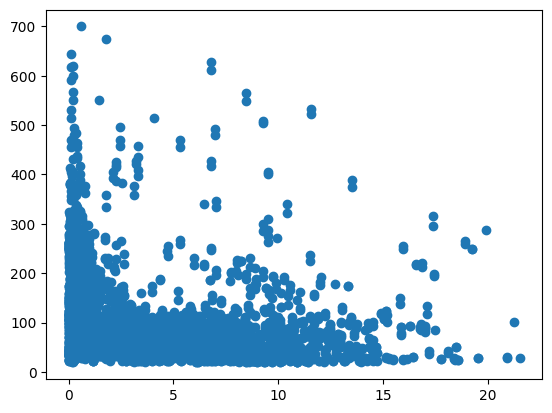

In [12]:
plt.scatter(x=df_flat['speed'], y=df_flat['no2'])
plt.show()

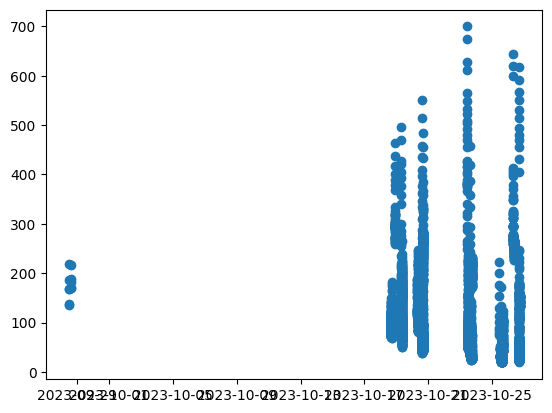

In [13]:
plt.plot(df_flat['datetime'],df_flat['no2'],'o')
plt.show()

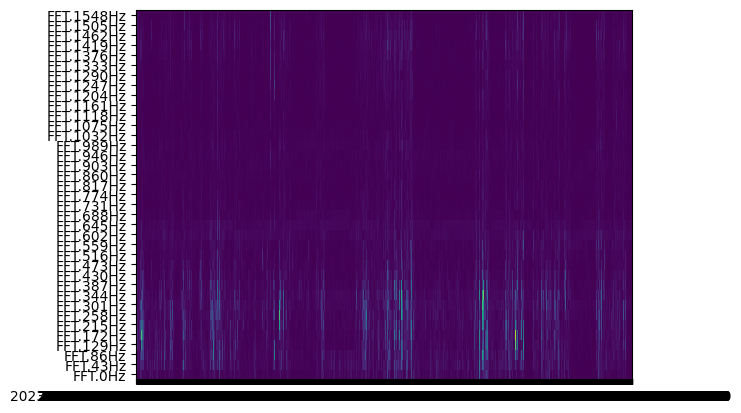

In [15]:
bins = df_flat.filter(like='FFT').columns

plt.pcolor(df_flat.filter(like='FFT').T)
plt.yticks(np.arange(0.5, bins.size, 1), bins)
plt.xticks(np.arange(0.5, len(df_flat.index), 1), df_flat.datetime)
plt.show()

In [ ]:
plt.plot(df_flat.co)
plt.show()

In [ ]:
# if we want to filter out some part of the data based on time, this is how we do it.

start_time = pytz.timezone('UTC').localize(datetime(2023, 10, 23, 10, 55))
end_time = datetime.now(pytz.timezone('UTC'))

mask = (df_flat['datetime'] > start_time) & (df_flat['datetime'] < end_time)

In [ ]:
# we can the get only those rows that are within the time range we are looking for by dooing this:
df_flat[mask]

In [ ]:
freq=[]
corr=[]
for bin in bins:
    freq.append(bin)
    corr.append(df_flat[mask]['speed'].corr(df_flat[mask][bin]))
    
df_FFTCorrilation = pd.DataFrame({'Frequency':freq, 'Corrilation':corr})
df_FFTCorrilation

plt.plot(-df_FFTCorrilation['Corrilation'])
plt.show()

In [ ]:
plt.scatter(df_flat[mask].filter(like='FFT').sum(axis='columns'), df_flat[mask]['speed'])
plt.show()